---

# Задание

Данное задание рассчитано на 2 дня для группы из двух или трех человек. Основная цель задания - произвести очистку данных.

### 1. Загрузите данные о продаже квартир:
- train_sber.csv - данные для обучения

Например:

План.
0. Проверить уникальность ID, если совпадают, удалить.
1. Найти признаки, не несущие существенной информации. Для релевантности признака построим график зависимости цены от значения этого признака.
2. В таблицу в столбец "комментарий" внести "несущественный признак", в солбец "управление - "удалить". Удалить эти признаки.
3. Определим выбросы методом коробочек.
4. Определим ошибочные значения, посмотрев на количество уникальных значений.
5. Жилую площадь найдем так: возьием квартиры с такой же общей площадью, количеством комнат и размером кухни. Если есть точное совпадение, то заполним так же, если нет, то умножим общую площадь на коэффициент жилая/общая, посчитанный из остальных известных данных.
6. Этаж - низкий процент пропущенных значений, заполним значением 2, так как он не верхний и не нижний и присутствует в доме любой этажности.
7. Количество этажей, материал и год постройки заполним мат.ожиданием по району.
8. Количество комнат и размер кухни заполним по среднему для такой общей площади.
9. Данные по кафе заполним следующим образом: каждый более близкий показатель равен более дальнему/на 3,14*разность квадратов радиусов. Если нет никаких данных, заполняем средним значениеп по всей таблице.
10. Состояние квартиры заполним или по среднему или по композиции общей площади и года постройки.
11. Посмотрим на наиболее существенные признаки и попытаемся найти ошибки. Для этого выведем количество уникальных.
12. Определим выбросы методом коробочек.
13. Из макроэкономических показателей берем курс доллара и пересчитываем цену в долларах, но только если в этот период было существенное изменение курса.
14. Объединить признаки: - экологичности, инфраструктуры, транспортной доступности. Сформировать из них признак привлекательности района

In [ ]:
# Начало работы

# Импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import pylab
import seaborn as sns
#plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (21, 14)
import itertools
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Сброс ограничений на число выводимых столбцов
pd.set_option('display.max_columns', None)

# Подключение гугл-диска
from google.colab import drive 
drive.mount('/content/drive')

# Загрузка данных
df = pd.read_csv('/content/drive/MyDrive/Pyton/train_sber.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Изменим количество выводимых ячеек таблицы 

pd.options.display.max_rows = 300

In [ ]:
df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

Вам доступны еще два файла с информацией:
- data_dictionary.docx - описание всех признаков (в папке misc)
- macro.csv - макроэкономические показатели (в папке misc)

---

### 2. Проведите очистку данных

Во время очистки данных вам необходимо заполнить таблицу:

In [ ]:
# Посчитаем количество пропущенных значений

df1 = df.isnull().sum(axis = 0).to_frame()
df1

In [ ]:
# Создадим таблицу для итогов.

columns = ['Признак', 'Количество пропущенных значений', 'Количество ошибочных значений', 
           'Количество выбросов', 'Управление', 'Комментарий']
data_clean = pd.DataFrame(columns=columns)
data_clean.Признак = df.columns
data_clean

,Признак,Количество пропущенных значений,Количество ошибочных значений,Количество выбросов,Управление,Комментарий
0,id,NaN,NaN,NaN,NaN,NaN
1,timestamp,NaN,NaN,NaN,NaN,NaN
2,full_sq,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
289,sport_count_5000,NaN,NaN,NaN,NaN,NaN
290,market_count_5000,NaN,NaN,NaN,NaN,NaN
291,price_doc,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Внесем количество пропущенных значений в таблицу

data_clean['Количество пропущенных значений'] = list(df1[0])
data_clean

,Признак,Количество пропущенных значений,Количество ошибочных значений,Количество выбросов,Управление,Комментарий
0,id,0,NaN,NaN,NaN,NaN
1,timestamp,0,NaN,NaN,NaN,NaN
2,full_sq,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
289,sport_count_5000,0,NaN,NaN,NaN,NaN
290,market_count_5000,0,NaN,NaN,NaN,NaN
291,price_doc,0,NaN,NaN,NaN,NaN


In [ ]:
# Импортируем таблицу в excel, чтобы было удобнее заполнять

data_clean.to_excel('/content/drive/MyDrive/Pyton/data_clean1'+'.xlsx', index=False)

In [ ]:
# Выведем строки с пропущенными значениями

data_clean[data_clean['Количество пропущенных значений'] != 0]

In [ ]:
# Проверим уникальность ID

len(df['id'].unique())

30471

Вывод. Ошибок в id нет

Проверим важность признаков. Посмотрим, зависит ли цена от изменения признака.

In [ ]:
# Строим графики по знаполненным значениям (не NAN)

df2 = df[df.max_floor.notnull()].sort_values(by='max_floor') # not NaN
plt.scatter(df2.max_floor, df2.price_doc)
plt.show()


Вывод - не наблюдается явной зависимости цены от признака этажности

Посмотрим для остальных признаково, которыми, возможно, можно принебречь

In [ ]:
df2 = df[df.material.notnull()].sort_values(by='material') # not NaN
plt.scatter(df2.material, df2.price_doc)
plt.show()

Признак материал показал зависимость от него цены, его убирать нельзя

Посмотрим на год постройки. В нем обнаружилось много неправильных данных. Исправим их.

In [ ]:
df2 = df[df.build_year.notnull()] # not NaN
#len(df2[df2.build_year != 0])
df2.loc[(df2.build_year > 2022), 'build_year'] = 2009
df2 = df2.sort_values(by='build_year')
df2 = df2[df2.build_year > 1800] # Посмотрим на распределение цены в домах, у которых значение года около нуля, найдем похожее
plt.scatter(df2.build_year, df2.price_doc)
plt.show()

In [ ]:
# Исправим значения года постройки

df.loc[(df.build_year > 2022), 'build_year'] = 2009
df.loc[(df.build_year < 1860), 'build_year'] = 1985

Продолжим изучение важности признаков

In [ ]:
df2 = df[df.build_count_block.notnull()].sort_values(by='build_count_block') # not NaN
plt.scatter(df2.build_count_block, df2.price_doc)
plt.show()

In [ ]:
df2 = df[df.hospital_beds_raion.notnull()].sort_values(by='hospital_beds_raion') # not NaN
plt.scatter(df2.hospital_beds_raion, df2.price_doc)
plt.show()

Этот признак тоже несущественный

In [ ]:
df2 = df[df.hospital_beds_raion.notnull()].sort_values(by='hospital_beds_raion') # not NaN
plt.scatter(df2.hospital_beds_raion, df2.price_doc)
plt.show()

Делаем вывод, что все признаки, относящиеся к информации по району не несут существенной информации. Эти столбцы можно удалить.

In [ ]:
df2 = df[df.school_quota.notnull()].sort_values(by='school_quota') # not NaN
plt.scatter(df2.school_quota, df2.price_doc)
plt.show()

In [ ]:
df2 = df[df.preschool_quota.notnull()].sort_values(by='preschool_quota') # not NaN
plt.scatter(df2.preschool_quota, df2.price_doc)
plt.show()

In [ ]:
df2 = df[df.build_count_before_1920.notnull()].sort_values(by='build_count_before_1920') # not NaN
plt.scatter(df2.build_count_before_1920, df2.price_doc)
plt.show()

In [ ]:
df2 = df[df.metro_min_walk.notnull()].sort_values(by='metro_min_walk') # not NaN
plt.scatter(df2.metro_min_walk, df2.price_doc)
plt.show()

In [ ]:
df2 = df[df.bulvar_ring_km.notnull()].sort_values(by='bulvar_ring_km') # not NaN
plt.scatter(df2.bulvar_ring_km, df2.price_doc)
plt.show()

После проверки всех признаков выделили существенные, остальные можно удалить.

In [ ]:
# Оставим в датафрейме только существенные признаки.

df_main = df[['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'sub_area', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'shopping_centers_raion', 'office_raion', 'big_market_raion', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'metro_km_walk', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'public_transport_station_min_walk', 'water_km', 'water_1line', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km']]
df_main

,id,timestamp,full_sq,life_sq,floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,shopping_centers_raion,office_raion,big_market_raion,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_km_walk,green_zone_km,industrial_km,water_treatment_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,Bibirevo,6.407578e+06,155572,0.189727,0.000070,16,1,no,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,211.0,0.0,0.0,0.0,206.0,5.0,1.131260,0.600973,1.080934,23.683460,3.299822,0.992631,no,1.422391,10.918587,13.100618,13.675657,15.156211
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,3,0,no,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,0.0,244.0,1.0,1.0,143.0,84.0,15.0,0.635053,0.065321,0.966479,1.317476,0.783160,0.698081,no,9.503405,3.103996,6.444333,8.132640,8.698054
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,0,1,no,330.0,59.0,0.0,0.0,206.0,4.0,60.0,0.0,1.0,0.0,330.0,1.0,0.0,246.0,63.0,20.0,1.445960,0.453172,0.939275,4.912660,3.945073,0.468265,no,5.604800,2.927487,6.963403,8.054252,9.067885
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,Mitino,1.258354e+07,178473,0.194703,0.069753,11,4,no,458.0,9.0,51.0,12.0,124.0,50.0,201.0,0.0,9.0,2.0,459.0,13.0,24.0,40.0,130.0,252.0,0.963802,0.106125,0.451173,15.623710,1.579164,1.200336,no,2.677824,14.606501,17.457198,18.309433,19.487005
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,Basmannoe,8.398461e+06,108171,0.015234,0.037316,10,93,no,746.0,48.0,0.0,0.0,643.0,16.0,35.0,0.0,3.0,1.0,746.0,371.0,114.0,146.0,62.0,53.0,0.688859,0.236214,0.392871,10.683540,0.857764,0.820294,no,11.616653,1.721834,0.046810,0.787593,2.578671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,2015-06-30,44,27.0,7.0,1.0,1975.0,2.0,6.0,3.0,Otradnoe,1.005305e+07,175518,0.096270,0.300323,9,6,no,282.0,35.0,0.0,0.0,20.0,5.0,222.0,0.0,0.0,0.0,282.0,0.0,0.0,14.0,246.0,22.0,0.679841,0.139814,0.702853,22.746320,1.119101,0.979218,no,3.762408,8.361875,10.543724,11.118577,12.599292
30467,30470,2015-06-30,86,59.0,3.0,2.0,1935.0,4.0,10.0,3.0,Tverskoe,7.307411e+06,75377,0.065444,0.000078,23,141,no,651.0,19.0,27.0,4.0,529.0,25.0,41.0,0.0,5.0,1.0,650.0,263.0,105.0,154.0,71.0,57.0,0.781217,0.271861,0.473020,13.867820,1.088544,1.063533,no,13.100989,1.238732,1.203215,1.874868,3.269284
30468,30471,2015-06-30,45,NaN,10.0,1.0,NaN,1.0,1.0,1.0,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,1,0,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.722233,0.427248,0.353642,16.784630,7.560163,0.394422,no,7.123215,17.148737,19.868997,21.038561,21.905792
30469,30472,2015-06-30,64,32.0,5.0,1.0,2003.0,2.0,11.0,2.0,Obruchevskoe,6.050065e+06,78616,0.167526,0.093443,4,5,no,185.0,38.0,0.0,0.0,4.0,9.0,134.0,0.0,0.0,0.0,186.0,0.0,0.0,84.0,36.0,66.0,2.047312,0.227547,2.397723,11.397520,3.138330,0.738539,no,2.327138,8.940313,11.752036,12.872535,13.622569


# Нахождение ошибок

In [ ]:
# Чтобы понять, до какого минимального значения площади данные скорее всего ошибочны,  найдем момент, с которого количество квартир с такой площадью становится больше 1.
# Чтобы посмотреть гистограмму для маленьких площадей.Для удобного формата вывода уберем большие значения площадей.

df2 = df[df.full_sq.notnull()] # not NaN
df2.loc[(df2.full_sq > 50), 'full_sq'] = 50


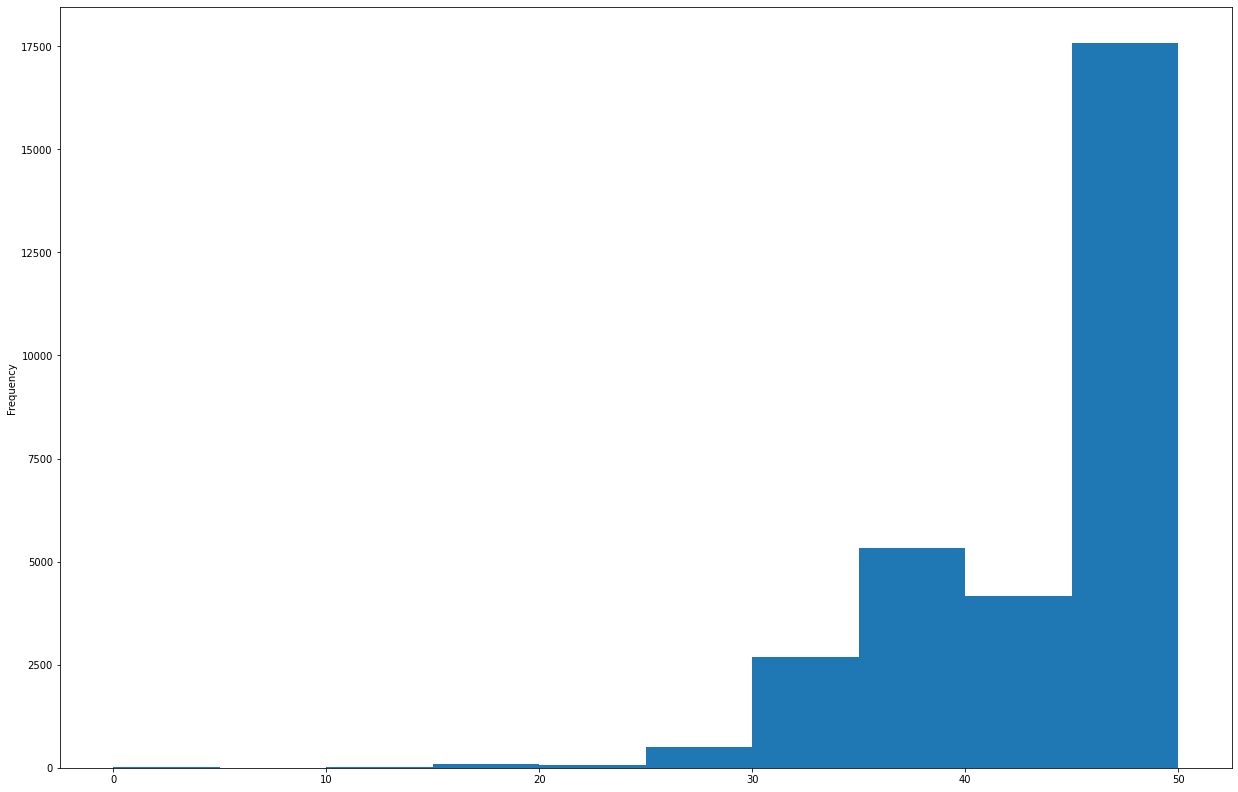

In [ ]:
df2['full_sq'].plot(kind = 'hist')
#lt.hist(df['full_sq'].sort_values(), density=True)

Вывод. Квартиры с площадью меньше 25 - ошибка

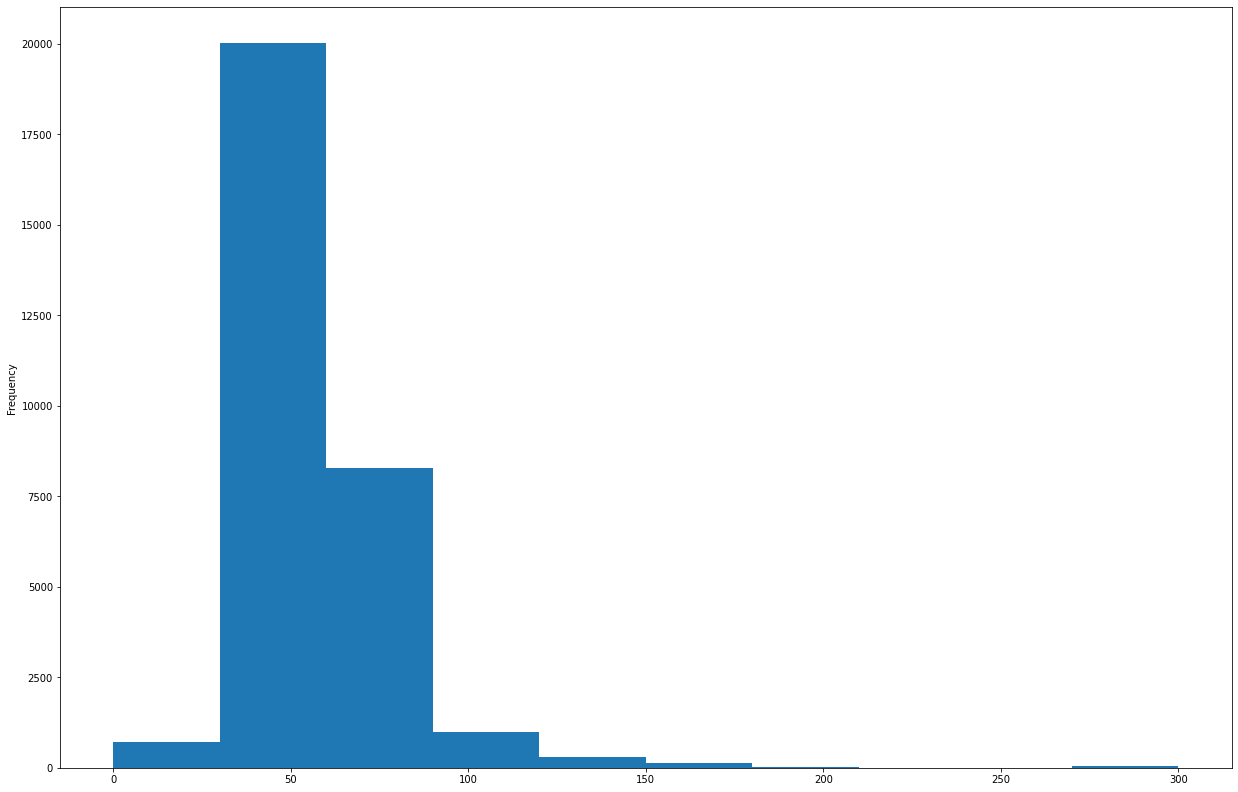

In [ ]:
# Чтобы понять, после какого максимального значения площади данные скорее всего ошибочны,
# найдем момент, с которого количество квартир с такой площадью становится не больше 1.
# Чтобы посмотреть гистограмму для больших площадей для удобного формата вывода скомпануем большие значения площадей

df2 = df[df.full_sq.notnull()] # not NaN
df2.loc[(df2.full_sq > 200), 'full_sq'] = 300
df2['full_sq'].plot(kind = 'hist')

Вывод. Квартиры с площадью больше 180 - ошибка

In [ ]:
# Для дальнейшего использования возьмем таблицу только с заполненнными строками

df2 = df[df.full_sq.notnull()] # not NaN

In [ ]:
# Посчитаем количество ошибок на малых площадях

len(df2[df2.full_sq < 25])

210

In [ ]:
# Посчитаем количество ошибок на больших площадях

len(df2[df2.full_sq > 180])

54

Ошибочных значений в общей площади - 264

# Управление выбросами

In [ ]:
# Функция, которая позволит получать значения усов коробчатой диаграммы:

def moustache(s):
    q75,q25 = np.percentile(s,[75,25])
    iqr = q75 - q25
    return q25 - 1.5*iqr, q75 + 1.5*iqr

In [ ]:
# Посчитаем границы выбросов

moustache(df2.full_sq)

(0.5, 100.5)

In [ ]:
# Посчитаем количество, которое попадает за границы выбросов
# Не забудем, что из них 54 - ошибочные

len(df2[df2.full_sq > 100])

961

Исправим данные

In [ ]:
# Заменим ошибочные и неопределенные данные медианным значением

df.loc[(df.full_sq.isna() == True), 'full_sq'] = df2.full_sq.median()
df.loc[(df.full_sq > 180), 'full_sq'] = df2.full_sq.median()
df.loc[(df.full_sq < 25), 'full_sq'] = df2.full_sq.median()
df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [ ]:
# Конвертируем таблицу с итогами

df_clean = pd.read_excel('/content/drive/MyDrive/Pyton/data_clean1.xlsx')
pd.options.display.max_rows = 6
df_clean

,Признак,Количество пропущенных значений,Количество ошибочных значений,Количество выбросов,Управление,Комментарий
0,id,0.0,0.0,0.0,удалить,признак не релевантный
1,timestamp,0.0,0.0,0.0,удалить,признак не релевантный
2,full_sq,0.0,264.0,905.0,исправить,признак не релевантный
...,...,...,...,...,...,...
289,sport_count_5000,0.0,0.0,0.0,удалить,признак не релевантный
290,market_count_5000,0.0,0.0,0.0,удалить,признак не релевантный
291,price_doc,0.0,0.0,0.0,не трогать,целевая переменная


Допускается заполнение таблицы в Excel или любом ином табличном редакторе, с возможностью сохранения файла в формате xlsx или csv.

---

Особенности:
1. Количество пропущенных значений, Количество ошибочных значений и Количество выбросов следует определять до изменения датафрейма.
2. Под ошибкой понимается любое доказано неверное значение вне зависимости от природы его возникновения.
3. В колонку управление последовательно заносится информация об управлении пропущенными значениями, ошибками, выбросами и непосредственно самим признаком, как он трансформируется в данные для построения модели.
4. В комментарии заносится аргументация выбранного управления, а также любая информация, которая может быть интересна проверяющему.

***Внимание!*** Допускается единое управление признаком (удаление), если доказано, что он нерелевантен.

***Рекомендация!*** Если вы проводили какой-либо анализ или управление, но затем решили отказаться от него, закоментируйте это в файле решения и в таблице, возможно проверяющий это оценит.

---



---

### 3. Постройте регрессионную модель

Задание посвящено очистке данных, однако вам предлогается построить модель на основе линейной регрессии [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Это самая простая модель регрессии. Для демонстрации построим модель прогнозирования показателя *fare* в зависимости от показателей класса каюты, порта отправления и количества членов семьи:

In [ ]:
# Возьмем таблицу с нужными столбцами и удалим строки с NaN в floor

df_lr = df[['full_sq', 'floor', 'metro_min_walk', 'kremlin_km', 'price_doc']]
df_lr = df_lr.dropna()

In [ ]:
# Убедимся, что все данные заполнениы

df1 = df_lr.isnull().sum(axis = 0).to_frame()
df1

,0
full_sq,0
floor,0
metro_min_walk,0
kremlin_km,0
price_doc,0


In [ ]:
# Применим метод линейной регрессии и кросс-валидации

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

X = df_lr[['full_sq', 'floor', 'metro_min_walk', 'kremlin_km']].values
y = df_lr.price_doc.values

model = LinearRegression().fit(X, y)

scores = cross_val_score(model, X, y, cv=5)

print(model.score(X, y),scores)
print(model.intercept_, model.coef_)

0.43469469020846807 [0.30648016 0.42866684 0.45526535 0.4576307  0.42987096]
2426628.2146805385 [ 139619.86145115   47871.60064762    5516.95744592 -212939.50670064]


---

Получили, что модель объясняет 44% дисперсии на обучающей и 42% на тестовой выборке.

---

Удачи!